In [81]:
import sympy as sp
from sympy.combinatorics import Permutation, PermutationGroup
from sympy.combinatorics.permutations import Cycle
import numpy as np
from math import factorial
from itertools import permutations
from tqdm import tqdm
from matplotlib import pyplot as plt
from math import floor,ceil

plt.rcParams.update({'font.size': 22})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## General stuff
Applicable to Weingarten techniques for computing moments such as 
$$\mathbb{E}[(U\otimes U^*)^{\otimes k}] = \sum_{\pi\sigma \in S_k} \text{Wg}_q(\pi,\sigma) |T_\pi \rangle \langle T_\sigma|,$$
where $S_k$ is the $k$-element permutation group and $T_\alpha$ are the corresponding unitary permuting operators. Lastly, $\text{Wg}_q(\pi,\sigma)$ is the Weingarten matrix, which we construct below. Note that the vectorized objects $|T_\alpha\rangle$ are not orthogonal, so whenever we want to stick two of them together, we must appropriately account for the inner product matrix. This is the ``perm_matrix`` function below, which is the Gram matrix constructing 
$$G_q(\pi,\sigma) = q^{\text{cycles}(\pi^{-1}\sigma)}$$ 
and we have 
$$\text{Wg}_q(\pi,\sigma) = [G_q^{-1}](\pi,\sigma) $$


In [82]:
             ## acc to eq36 in https://quantum-journal.org/papers/q-2024-05-08-1340/pdf/ only the number of cycles is needed?
# Define the permutation norm
def norm(a):
    ### a: of the type (0,1...,n-1) or permutation thereof
    nn = len(a) 
    a = Permutation(a)
    cycles = a.cyclic_form
    return len(cycles) + nn - sum(len(c) for c in cycles)


# Define scalar product of permutations
def perm_product(a, b, q):
    a = Permutation(a)
    b = Permutation(b)
    a_inv = a**-1
    composed = (a_inv * b).array_form
    return q**norm(composed)

# Create matrix of scalar products
def perm_matrix(q,ncopies):
    perm = list(permutations(list(range(ncopies))))
    return sp.Matrix([
        [perm_product(a, b, q) for b in perm]
        for a in perm
    ])

# Compute Weingarten function matrix
def Wg(q,ncopies):
    ## q is the dimension 
    perm = list(permutations(list(range(ncopies))))
    return perm_matrix(q,ncopies).inv()

## 
def norm_pure(p,ncopies):
    norm_pure = (perm_matrix(p,ncopies) @ np.ones(factorial(ncopies), dtype=int))[1]
    return norm_pure

## Notations

$$d: \text{ dot dimension}$$
$$D: \text{ bath dimension}$$
$$T: \text{ number of IM sites}$$

Hence, for specified $(d,D,T)$ the IM $\mathcal{I}$ is a mixed state on $2T$ $d-$ dimensional qudits. Viewed as a quantum comb, it is a $T-$ site comb each with a $d-$ dimensional input and output space. 

In [140]:
### Transition matrices where boundaries of one qubit is left fixed, and 2m qubits are kept free 
### iterates upwards to add more IM sites
def transition_matrix(d, D, ncopies, b1, b2=None):
    ### if b2 is not specified, it is set to b1
    if b2 is None:
        b2 = b1
    wg = Wg(q = d * D, ncopies = ncopies) ## add d-dim IM channel => Dd dim
    perm = list(permutations(list(range(ncopies))))
    permproduct = perm_matrix(q=d,ncopies=ncopies) ### for contracting out the IM d.o.f. with specified bond dimension
    ## contract out incoming channel with b1 and outgoing channel with b2 
    return sp.Matrix([
        [permproduct[i, b2] * wg[i, j] * permproduct[j, b1]  for j in range(len(perm))] 
        for i in range(len(perm))
    ]) / d**ncopies 

## Compute $\text{tr}(\mathcal{I})$
Start the bath at infinite temperature and compute the trace. The following code computes $\text{tr}(\mathcal{I}^{\otimes\text{ncopies}})$ with trivial boundaries, so it should be one no matter the value of ``ncopies``. 

Without any external normalization, $\text{tr}(\mathcal{I}_{1:t}) = d^t$. So, we normalize the transfer matrix step by $1/d^\text{ncopies}$.

In [250]:
rho_IT = []
Nb = 20 
D = 2 ** Nb
d = 2. 
ncopies = 1 ## this is irrelevant here, shoukd get ans = 1 no matter what the number of copiesis
perm = list(permutations(list(range(ncopies))))
vec_t = np.eye(factorial(ncopies))[0] / D**ncopies 
vecs = [vec_t]
for t in tqdm(range(1,Nb+1)):
    T_tr = transition_matrix(d=d, D=D, ncopies=ncopies, b1=0)  
    ## get perm product on the 2m sites to propagate the TN upwards
    permproduct = perm_matrix(q=D, ncopies=ncopies) ## only D dim as the new IM d.o.f. will already be contracted in the TM 
    vec_t = T_tr @ permproduct @ vec_t
    vecs.append(vec_t)

## check 
np.all([np.transpose(np.eye(factorial(ncopies))[0]) @ np.array(perm_matrix(q=D,ncopies=ncopies) @ vecs[t]) == 1. for t in range(1,Nb+1)])

100%|██████████| 20/20 [00:00<00:00, 851.20it/s]


True

Plot $p_2(\mathcal{I}^{T_A})$ for $A = (1,r_A)$ as a function of $r_A$.

In [251]:
Nb = 32 ## fix bath size
D = 2 ** Nb 
d = 2.  

In [252]:
ncopies = 2
perm = list(permutations(list(range(ncopies))))
permproduct = perm_matrix(q=D, ncopies=ncopies)
t_ar = np.array(list(range(1,Nb+1)) )
p2s = np.zeros(Nb, dtype=float) 
for rA in range(1,Nb+1):
    ## first rA sites (both in and out) partial transposed
    vec_t = np.eye(factorial(ncopies))[0] / D**ncopies 
    bcs = [1] * rA + [0] * (Nb - rA) ## list of tm boundary conditions along temporal direction 
    for new_im_site in range(1,Nb+1):
        T_tr = transition_matrix(d=d, D=D, ncopies=ncopies, b1=bcs[new_im_site-1])
        vec_t = T_tr @ permproduct @ vec_t
    val = np.transpose(np.eye(factorial(ncopies))[0]) @ np.array(permproduct) @ vec_t 
    p2s[rA - 1] = val 

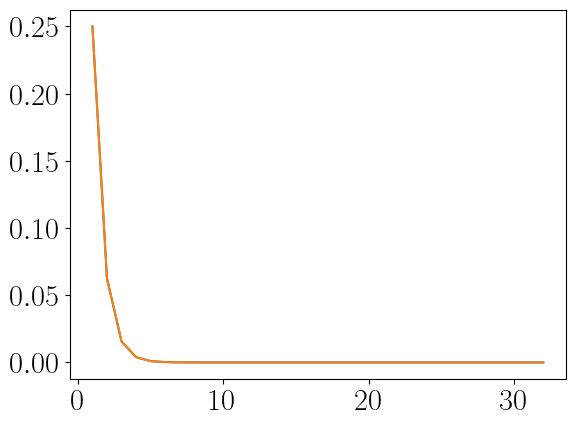

In [253]:
plt.plot(t_ar,p2s)
plt.plot(t_ar,d**(-2 * t_ar) + 1/D**2)

$p_3(\mathcal{I}^{T_A})$

In [254]:
ncopies = 3
perm = list(permutations(list(range(ncopies))))
permproduct = perm_matrix(q=D, ncopies=ncopies)
t_ar = np.array(list(range(1,Nb+1)) )
p3s = np.zeros(Nb, dtype=float) 
for rA in range(1,Nb+1):
    ## first rA sites (both in and out) partial transposed
    vec_t = np.eye(factorial(ncopies))[0] / D**ncopies 
    bcs = [perm.index((1,2,0))] * rA + [perm.index((0,1,2))] * (Nb - rA) ## list of tm boundary conditions along temporal direction 
    for new_im_site in range(1,Nb+1):
        T_tr = transition_matrix(d=d, D=D, ncopies=ncopies, b1=bcs[new_im_site-1])
        vec_t = T_tr @ permproduct @ vec_t
    val = np.transpose(np.eye(factorial(ncopies))[0]) @ np.array(permproduct) @ vec_t 
    p3s[rA - 1] = val 

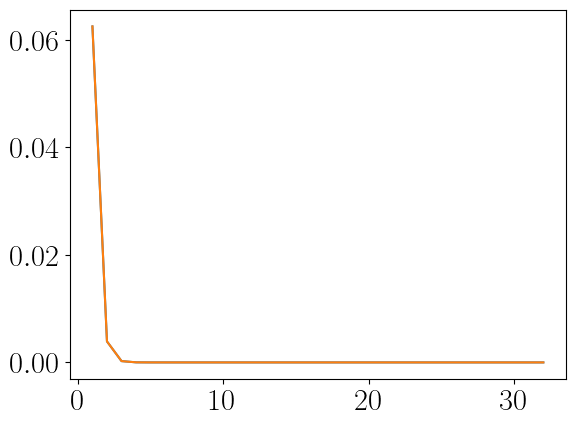

In [255]:
plt.plot(t_ar,p2s**2)
plt.plot(t_ar,p3s)
